In [21]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20, 16
import pmdarima as pm
import arch

In [78]:
df =  pd.read_excel(r'C:\Users\hakan\Desktop\transferedfiles\df_son.xlsx')
df

,Unnamed: 0,Date,CashIn,CashOut
0,0,2016-01-01,1276.0,6500.0
1,1,2016-01-02,1276.0,23110.0
2,2,2016-01-03,1276.0,7070.0
3,3,2016-01-04,1276.0,18520.0
4,4,2016-01-05,20840.0,22200.0
...,...,...,...,...
1181,1181,2019-03-27,45160.0,48600.0
1182,1182,2019-03-28,39480.0,22840.0
1183,1183,2019-03-29,70260.0,25950.0
1184,1184,2019-03-30,19250.0,24350.0


We set Date as an index of our dataframe

In [79]:
df.set_index('Date', inplace=True)

In [80]:
new_index = pd.date_range(df.index.min(), df.index.max())
print(new_index)

DatetimeIndex(['2016-01-01', '2016-01-02', '2016-01-03', '2016-01-04',
               '2016-01-05', '2016-01-06', '2016-01-07', '2016-01-08',
               '2016-01-09', '2016-01-10',
               ...
               '2019-03-22', '2019-03-23', '2019-03-24', '2019-03-25',
               '2019-03-26', '2019-03-27', '2019-03-28', '2019-03-29',
               '2019-03-30', '2019-03-31'],
              dtype='datetime64[ns]', length=1186, freq='D')


In [81]:
df_new = df.reindex(new_index, fill_value=0)

We are setting the dates start_date and end_date for our model.start_date2 and end_date2 will be used for testing.

In [82]:
from datetime import datetime
start_date = datetime(2016,1,1)
end_date = datetime(2017,12,31)
start_date2 = datetime(2018,1,1)
end_date2 = datetime(2018,4,20)

ts = df_new[(start_date <= df_new.index) & (df_new.index <= end_date)]
ts2 = df_new[(start_date2 <= df_new.index) & (df_new.index <= end_date2)]

We will divide CashIn/Cashout and taking the log for arranging variance.But there is a problem with the data, cause 2 elements in our data has CashOut value 0. So we will set that values to mean of the CashOut column.

In [85]:
for i in range(len(ts['CashOut'])):
    if ts['CashOut'][i] == 0 :
        print(i)

109
215


In [86]:
ts['CashOut'].mean()

27875.802123463487

In [87]:
print(ts['CashOut'][109])
print(ts['CashOut'][215])

0.0
0.0


In [88]:
ts['CashOut'][109] = ts['CashOut'].mean()
ts['CashOut'][215] = ts['CashOut'].mean()

In [89]:
ts2['CashIn/Cashout']=ts2['CashIn']/ts2['CashOut']
ts2['logDiff'] = np.log(ts2['CashIn/Cashout'])

In [90]:
ts2

,Unnamed: 0,CashIn,CashOut,CashIn/Cashout,logDiff
2018-01-01,731,22430.0,26630.0,0.842283,-0.171639
2018-01-02,732,48030.0,60140.0,0.798637,-0.224849
2018-01-03,733,62370.0,32410.0,1.924406,0.654617
2018-01-04,734,46750.0,26390.0,1.771504,0.571829
2018-01-05,735,25870.0,87760.0,0.294781,-1.221522
...,...,...,...,...,...
2018-04-16,836,52880.0,52680.0,1.003797,0.003789
2018-04-17,837,35280.0,34310.0,1.028272,0.027879
2018-04-18,838,27710.0,28460.0,0.973647,-0.026706
2018-04-19,839,68490.0,25650.0,2.670175,0.982144


In [91]:
ts['CashIn/Cashout'] = ts['CashIn']/ts['CashOut']
ts['logDiff'] = np.log(ts['CashIn/Cashout'])

In [92]:
ts.isnull().sum()

Unnamed: 0        0
CashIn            0
CashOut           0
CashIn/Cashout    0
logDiff           1
dtype: int64

We have 1 na value for logDiff so we will replace it with 0

In [93]:
ts['logDiff'].fillna(0, inplace=True)

In [94]:
ts.isnull().sum()

Unnamed: 0        0
CashIn            0
CashOut           0
CashIn/Cashout    0
logDiff           0
dtype: int64

In [95]:
ts['logDiff'].isnull().sum()

0

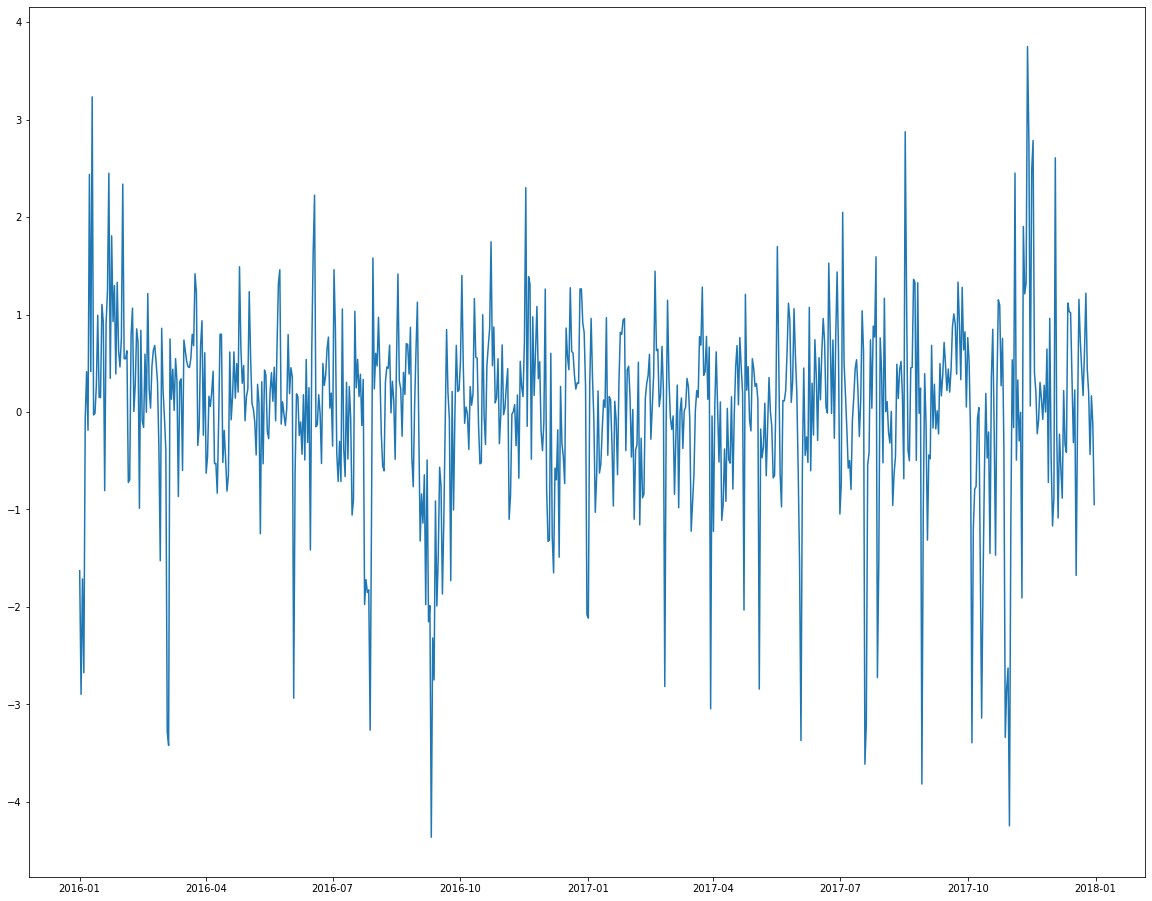

In [96]:
plt.plot(ts['logDiff'])

Looking plot above seems like centered around 0 mean

### Additive Time Series
For additive time series is simply: $O_{t} = T_{t} + S_{t} + R_{t}$ 

$O_{t}$ is the output   
$T_{t}$ is the trend  
$S_{t}$ is the seasonality  
$R_{t}$ is the residual  
$_t$ is a variable representing a particular point in time

Now we will decompose the timeseries. We are using period=30 cause we are working on daily data.

In [99]:
from statsmodels.tsa.seasonal import seasonal_decompose

ss_decomposition = seasonal_decompose(ts['logDiff'] , model='additive', period=30)
estimated_trend = ss_decomposition.trend
estimated_seasonal = ss_decomposition.seasonal
estimated_residual = ss_decomposition.resid

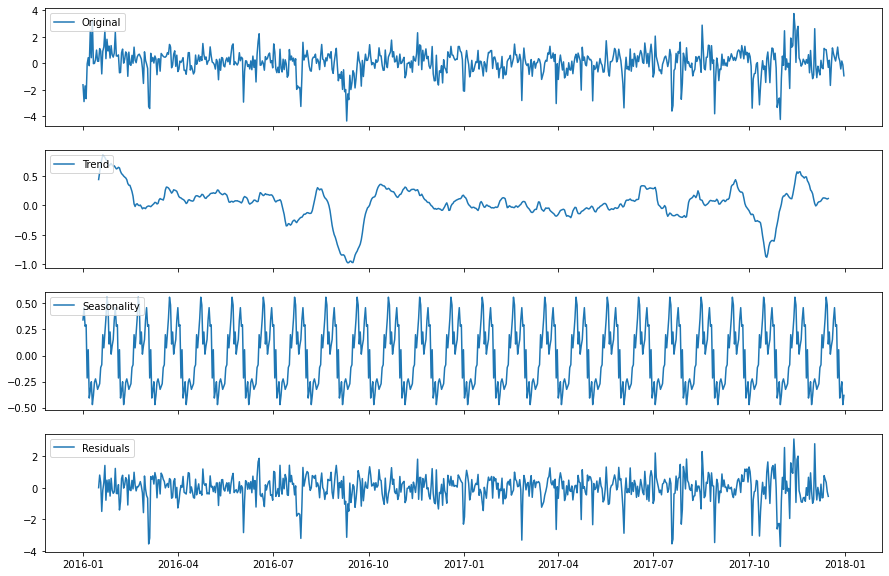

In [100]:
fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(15)

axes[0].plot(ts['logDiff'], label='Original')
axes[0].legend(loc='upper left');

axes[1].plot(estimated_trend, label='Trend')
axes[1].legend(loc='upper left');

axes[2].plot(estimated_seasonal, label='Seasonality')
axes[2].legend(loc='upper left');

axes[3].plot(estimated_residual, label='Residuals')
axes[3].legend(loc='upper left');

We see that below from autocorrelation plot we see that only lag 1 , lag 2 , lag 3 is statistically significant

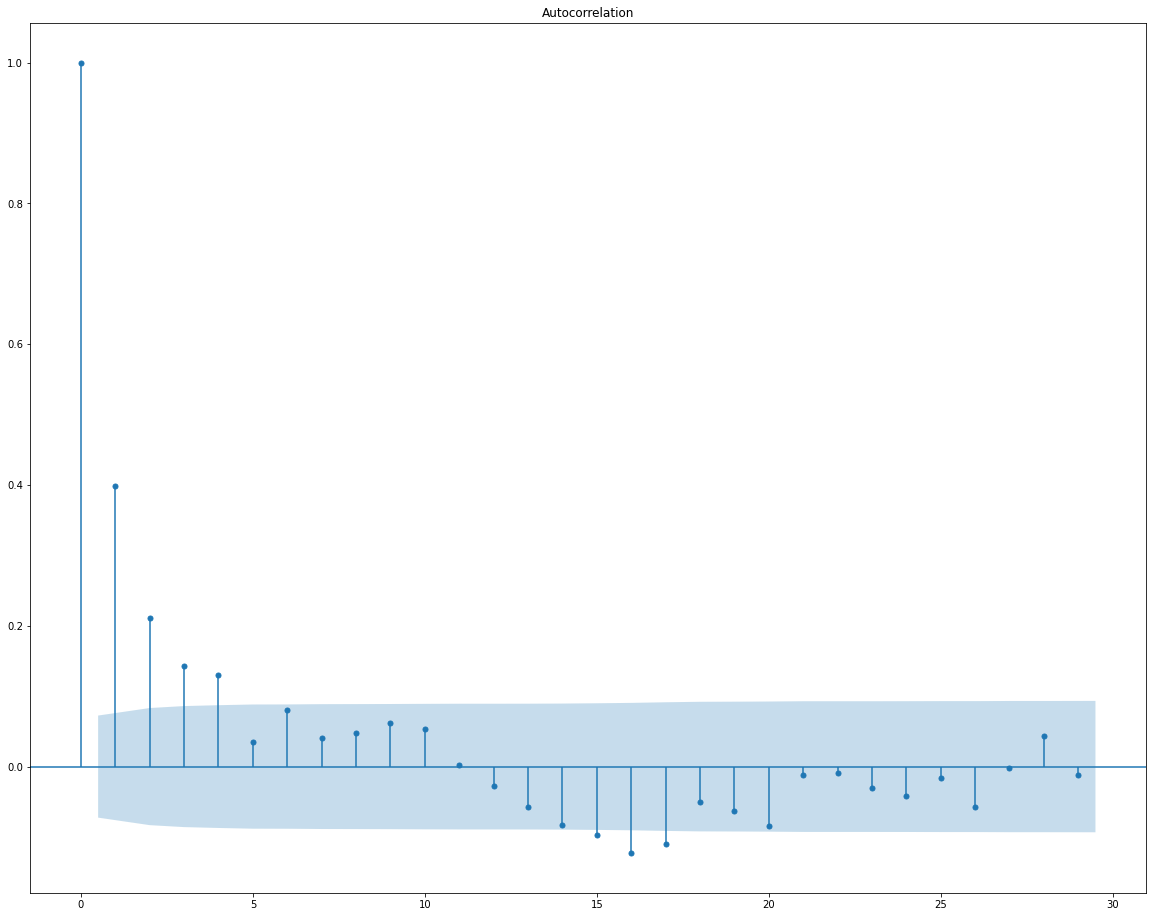

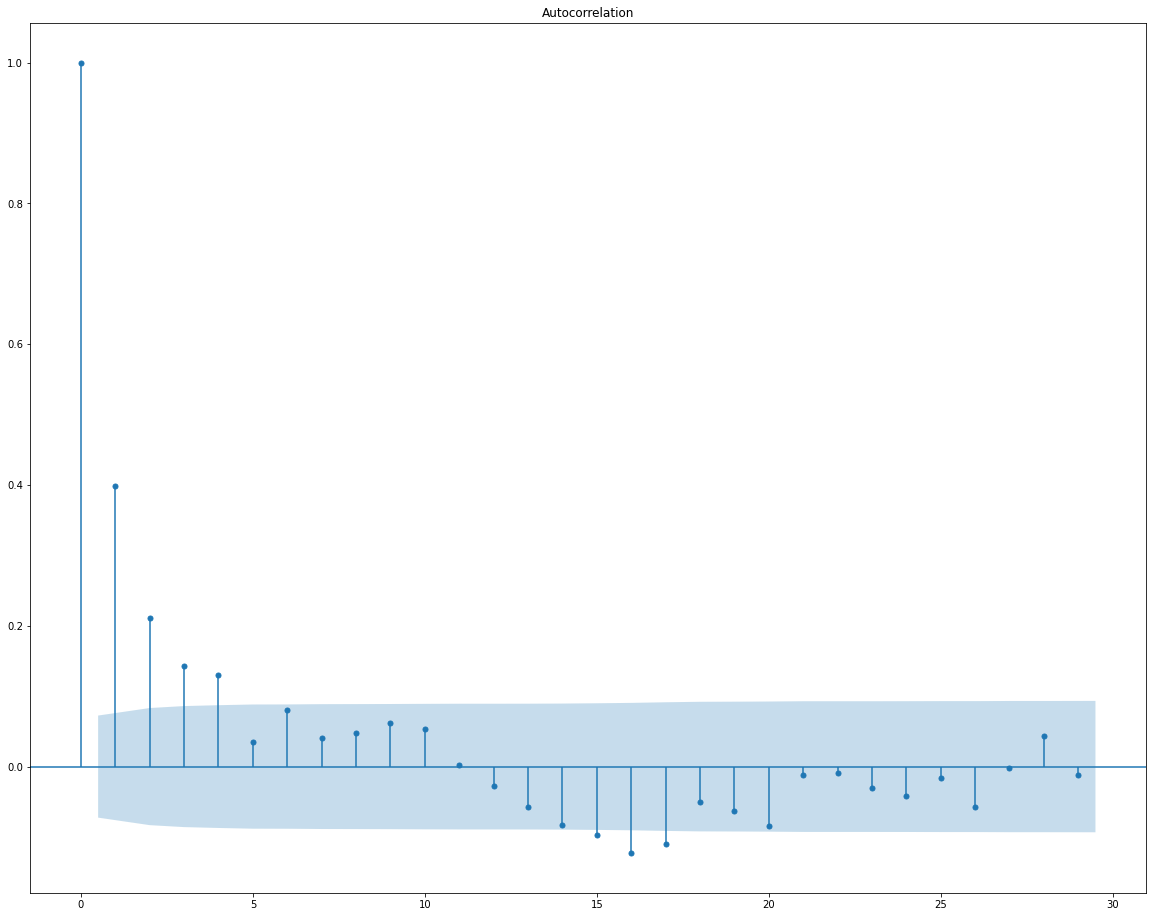

In [101]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(ts['logDiff'])

## Stationarity

### What is Stationarity?
In order for time series data to be stationary, the data must exhibit four properties over time:
1. constant mean
2. constant variance
3. constant autocorrelation structure
4. no periodic component

We will check our timeseries stationary or not.Splitting the data and calculating each section of the data will give us useful idea that the series is stationary or not.First we need to find length of the series cause it must be divisible by our section number.

In [102]:
len(ts['logDiff'])

731

In [103]:
chunks = np.split(ts['logDiff'], indices_or_sections=17)

In [104]:
np.mean(chunks, axis=1)

array([ 0.44084636,  0.11264588,  0.12975225,  0.09569578, -0.13716382,
       -0.35027161,  0.07275019,  0.04914833,  0.03201212,  0.03525708,
       -0.1429888 ,  0.08566045,  0.06359623,  0.0331008 ,  0.05624281,
       -0.09362783,  0.07718866])

In [105]:
np.var(chunks, axis=1)

array([1.42511874, 0.91873759, 0.28688194, 0.64892902, 0.91924574,
       1.36405253, 0.57929769, 0.65262887, 0.61148981, 0.54505389,
       0.54345674, 0.60864518, 0.78945671, 1.37501206, 1.04123726,
       2.86093841, 0.59417265])

As seen above , the means and variances for each section is close to each other so our data is close to stationary.Also we can check histogram.

<AxesSubplot:>

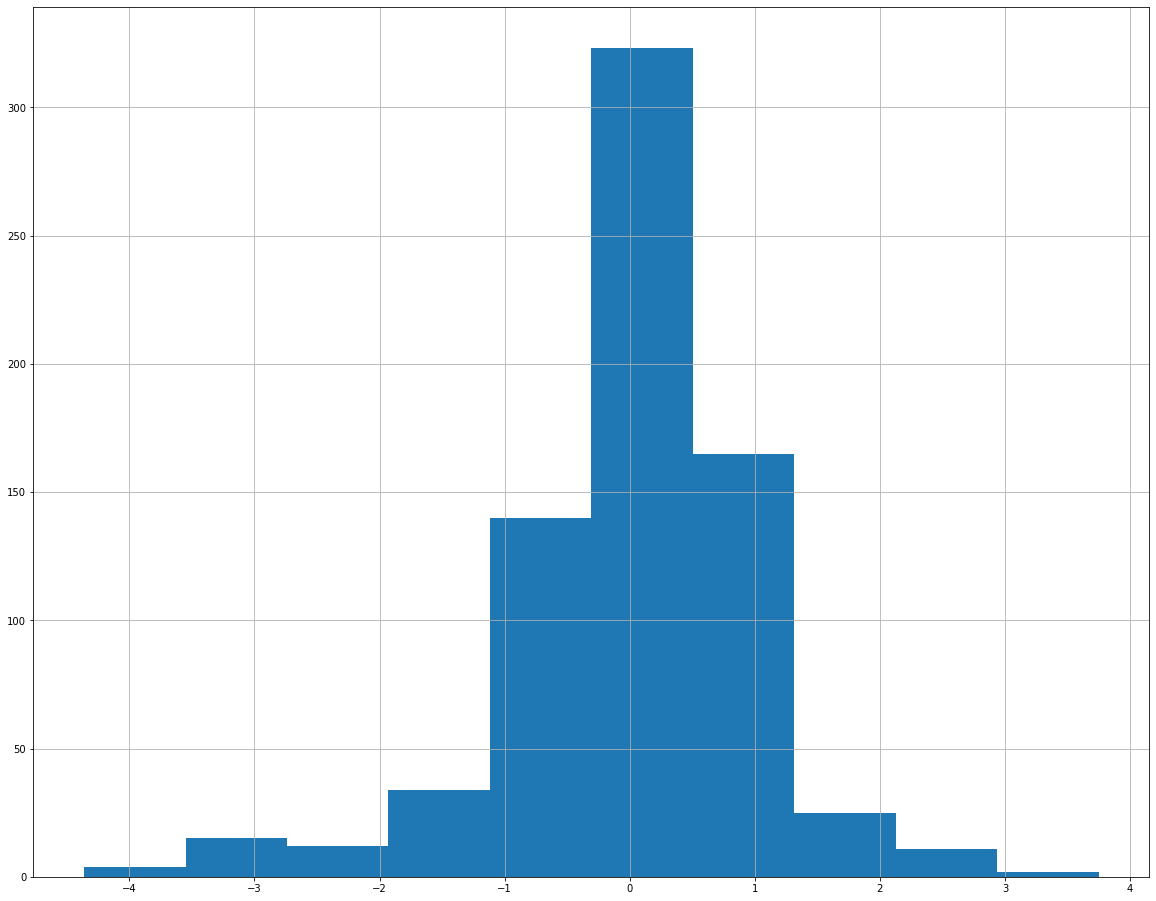

In [106]:
pd.Series(ts['logDiff']).hist()

The chart above is looks a little bit normal distribution we are close to stationarity

- Augmented Dickey-Fuller Test
    - Statistical tests for checking stationarity; the null hypothesis is that the timeseries is non-stationary. If our test statistic is below an `alpha` value, we _can_ reject the null hypothesis and say that the series is stationary.

In [107]:
from statsmodels.tsa.stattools import adfuller

adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(ts['logDiff'])

First, **adf** is the value of the test statistic. The more negative the value, the more confident we can be that the series is stationary. Here we see a value of -8.751737254953978. That may not mean anything to you just yet but the **pvalue** should.

In [108]:
print(adf)

-8.751737254953978


In [109]:
print(pvalue)

2.8245285790939254e-14


P value is small , so we reject the null hypothesis that this data is nonstationary.

## Smoothing

In [111]:
def dftest(timeseries):
    dftest = adfuller(timeseries)
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','p-value','Lags Used','Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.grid()
    plt.show(block=False)

In [112]:
ts.drop('Unnamed: 0',axis='columns', inplace=True)
ts.drop('CashIn',axis='columns', inplace=True)
ts.drop('CashOut',axis='columns', inplace=True)
ts.drop('CashIn/Cashout',axis='columns', inplace=True)

Test Statistic         -8.751737e+00
p-value                 2.824529e-14
Lags Used               5.000000e+00
Observations Used       7.250000e+02
Critical Value (1%)    -3.439402e+00
Critical Value (5%)    -2.865535e+00
Critical Value (10%)   -2.568897e+00
dtype: float64


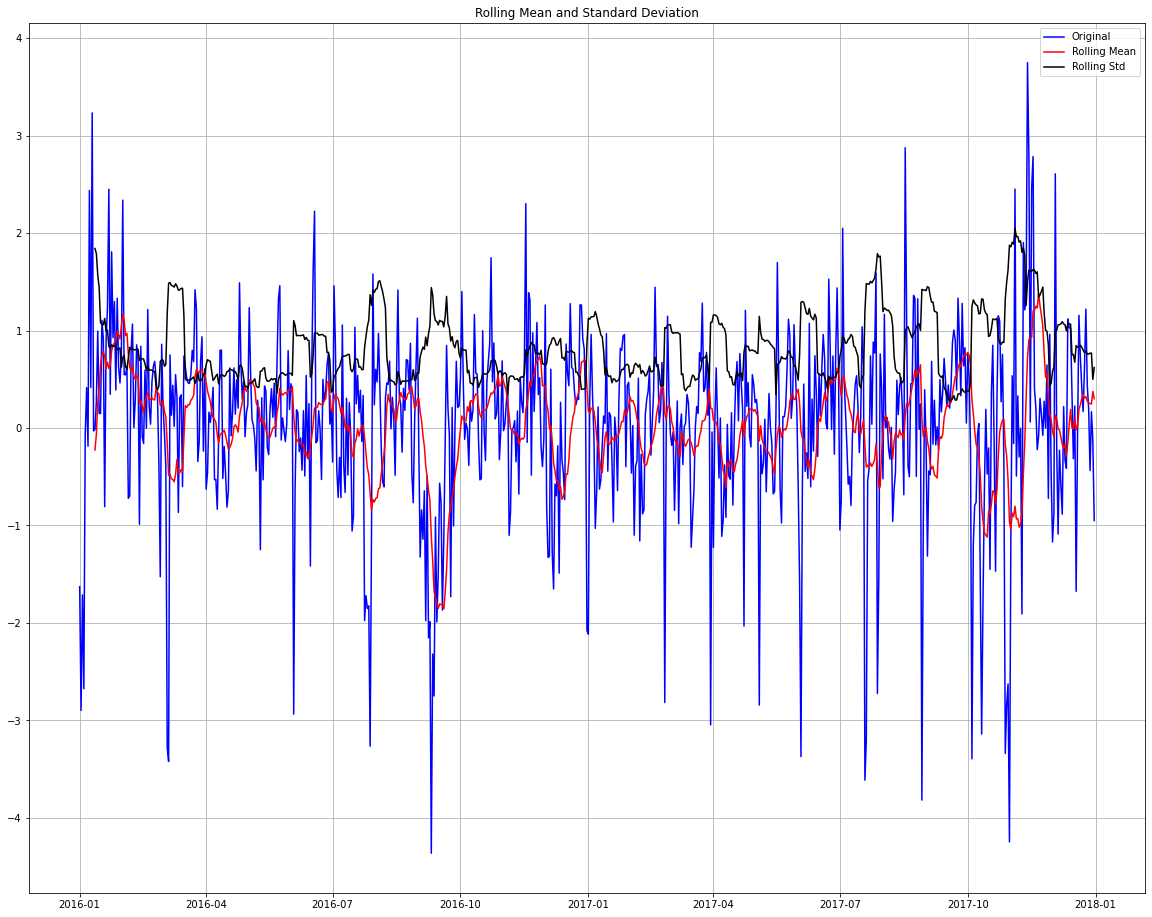

In [113]:
dftest(ts)

We define function called plots , it will be used for plotting raw data and its acf,pcf plots

In [115]:
def plots(data, lags=None):
    layout = (3, 1)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (1, 0))
    pacf = plt.subplot2grid(layout, (2, 0))
    
    raw.plot(data)
    sm.tsa.graphics.plot_acf(data, lags=lags, ax=acf, zero=False)
    sm.tsa.graphics.plot_pacf(data, lags=lags, ax=pacf, zero = False)
    sns.despine()
    plt.tight_layout()

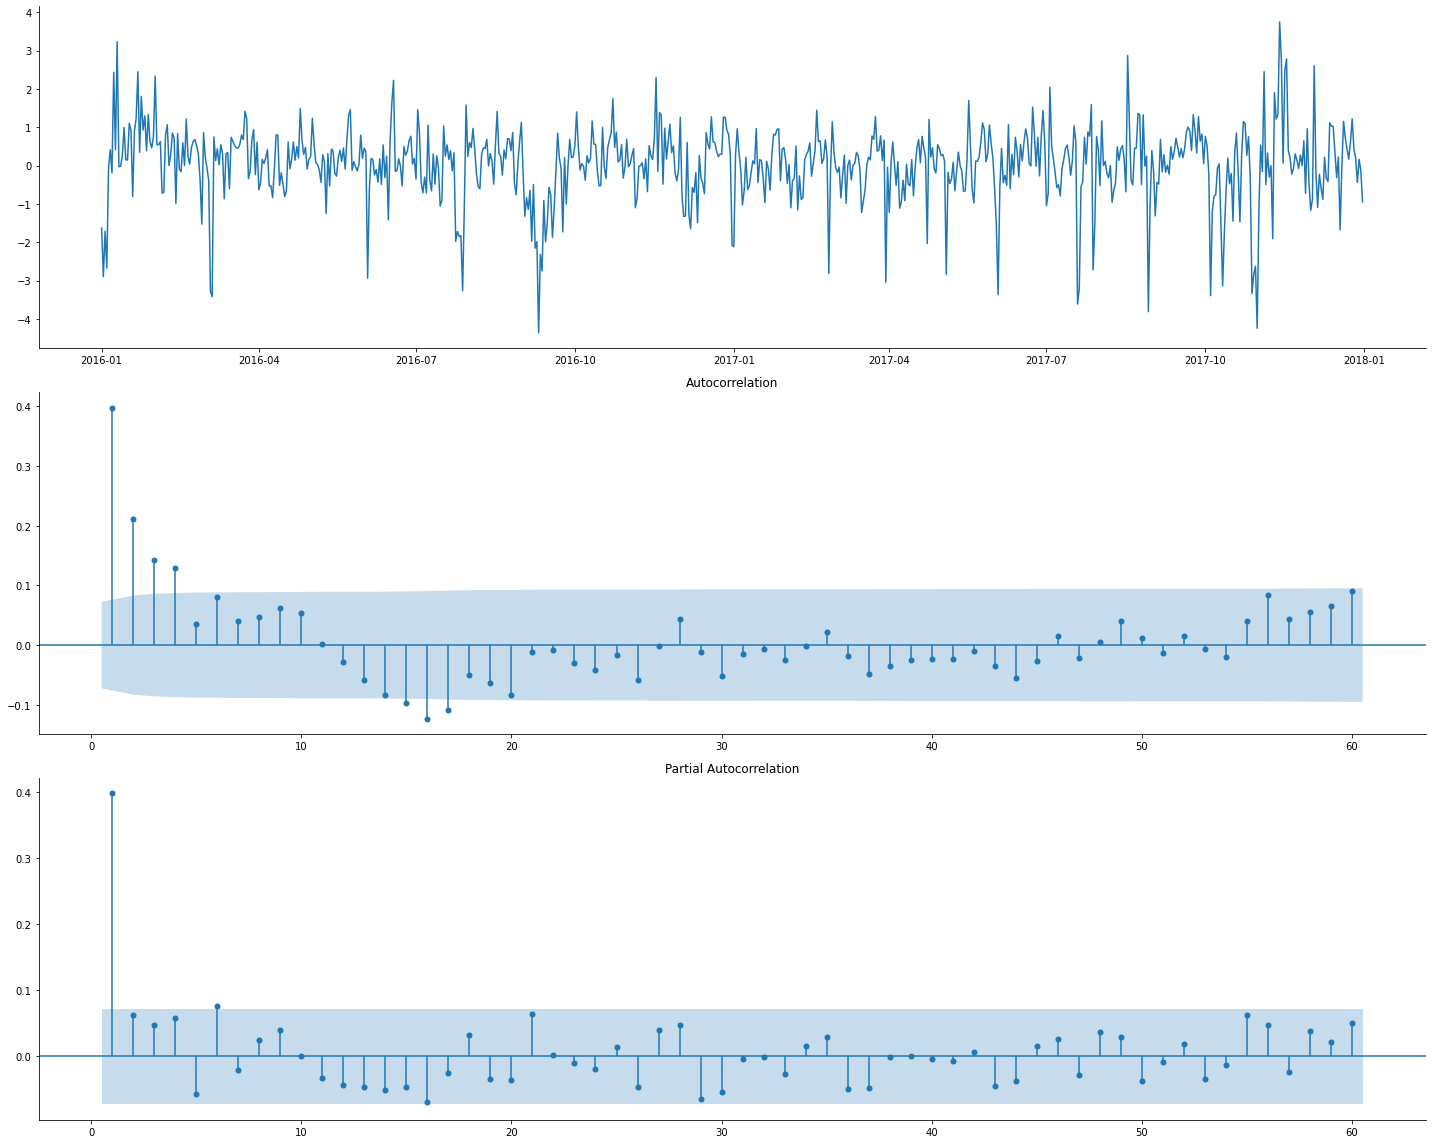

In [116]:
plots(ts['logDiff'], lags=60)

As we see on pacf plot there is a small relationship after 6 days so our period may be 1 week.

Auto_arima function from pmdarima will find best parameters according to AIC. We will take m=30 since we are using daily data.

In [117]:
stepwise_model = pm.auto_arima(ts, start_p=0, start_q=0,
                           max_p=3, max_q=3, m=30,
                           start_P=0, seasonal=True,
                           d=0, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,1)[30] intercept   : AIC=inf, Time=3.42 sec
 ARIMA(0,0,0)(0,1,0)[30] intercept   : AIC=2469.611, Time=0.12 sec
 ARIMA(1,0,0)(1,1,0)[30] intercept   : AIC=2110.411, Time=2.04 sec
 ARIMA(0,0,1)(0,1,1)[30] intercept   : AIC=inf, Time=9.11 sec
 ARIMA(0,0,0)(0,1,0)[30]             : AIC=2467.661, Time=0.18 sec
 ARIMA(1,0,0)(0,1,0)[30] intercept   : AIC=2353.986, Time=0.35 sec
 ARIMA(1,0,0)(2,1,0)[30] intercept   : AIC=2050.359, Time=5.22 sec
 ARIMA(1,0,0)(2,1,1)[30] intercept   : AIC=inf, Time=19.90 sec
 ARIMA(1,0,0)(1,1,1)[30] intercept   : AIC=inf, Time=6.67 sec
 ARIMA(0,0,0)(2,1,0)[30] intercept   : AIC=2125.544, Time=7.08 sec
 ARIMA(2,0,0)(2,1,0)[30] intercept   : AIC=2052.074, Time=8.30 sec
 ARIMA(1,0,1)(2,1,0)[30] intercept   : AIC=2051.983, Time=10.10 sec
 ARIMA(0,0,1)(2,1,0)[30] intercept   : AIC=2059.461, Time=5.73 sec
 ARIMA(2,0,1)(2,1,0)[30] intercept   : AIC=2051.422, Time=27.91 sec
 ARIMA(1,0,0)(2,1,0)[30]            

In [118]:
from dateutil.relativedelta import relativedelta
def future_preds_df(model,series,num_days):
    pred_first = series.index.max()+relativedelta(days=1)
    pred_last = series.index.max()+relativedelta(days=num_days)
    date_range_index = pd.date_range(pred_first,pred_last,freq = 'D')
    vals = model.predict(n_periods = num_days)
    return pd.DataFrame(vals,index = date_range_index)

In [119]:
preds = future_preds_df(stepwise_model,ts,100)

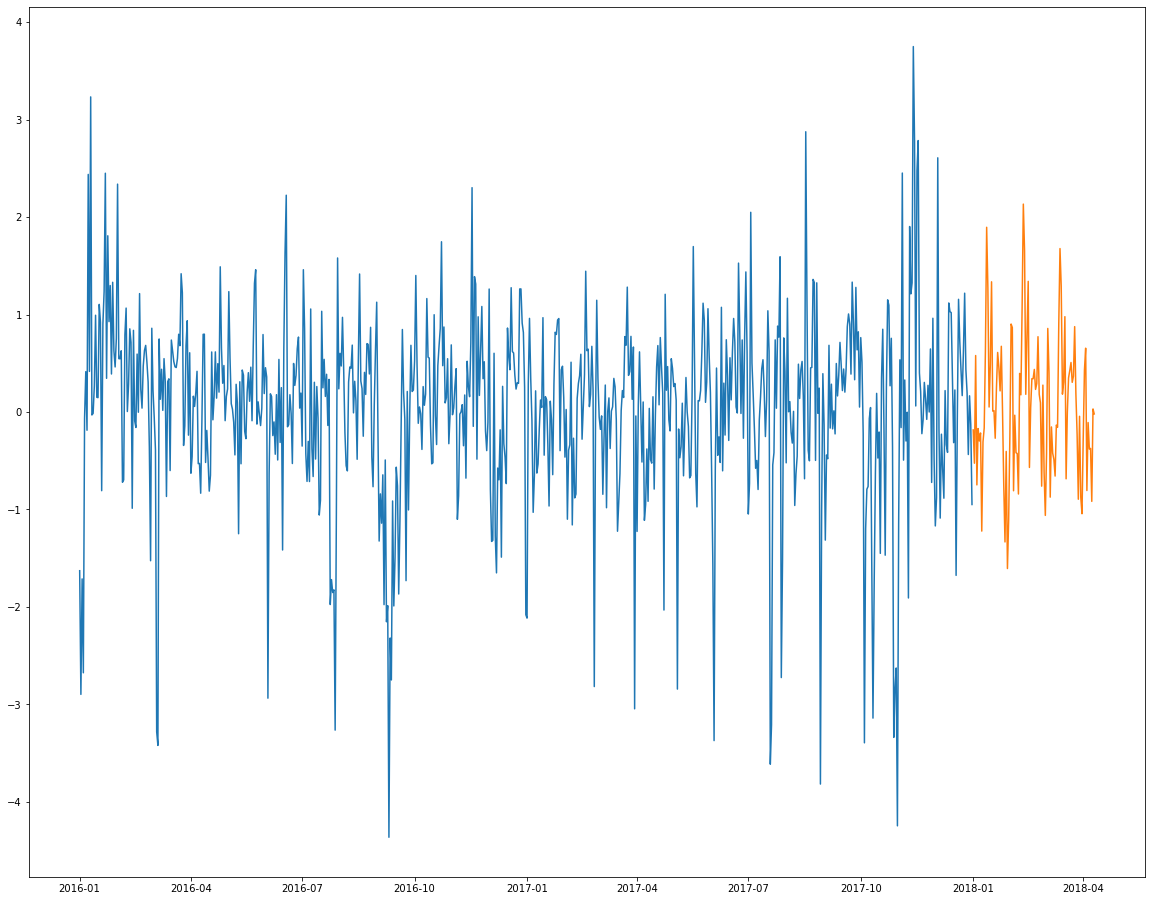

In [120]:
plt.plot(ts)
plt.plot(preds)

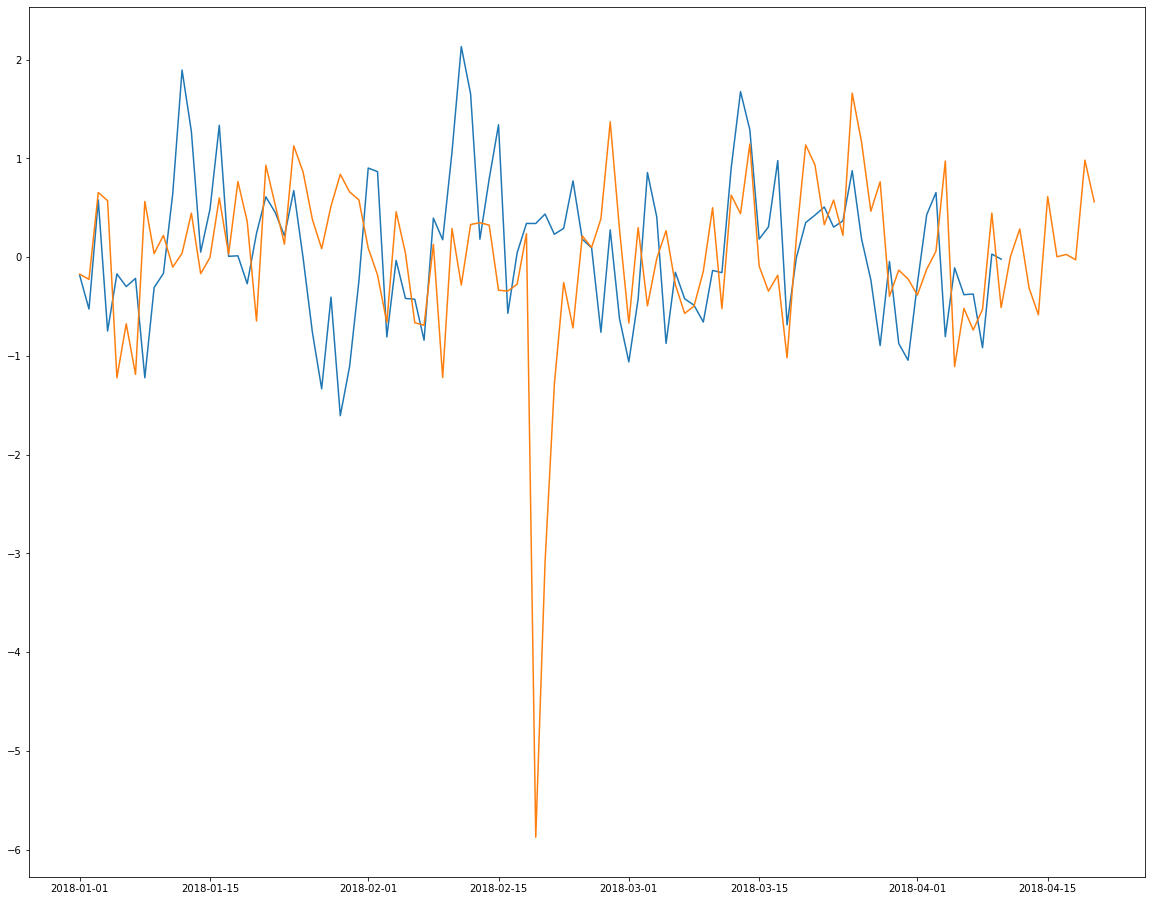

In [123]:
plt.plot(preds)
plt.plot(ts2['logDiff'])

In [132]:
min_index = ts2['logDiff'].idxmin()
min_index

Timestamp('2018-02-19 00:00:00', freq='D')

There is an exception on 19 February 2018. It may be some special event happened on that day.

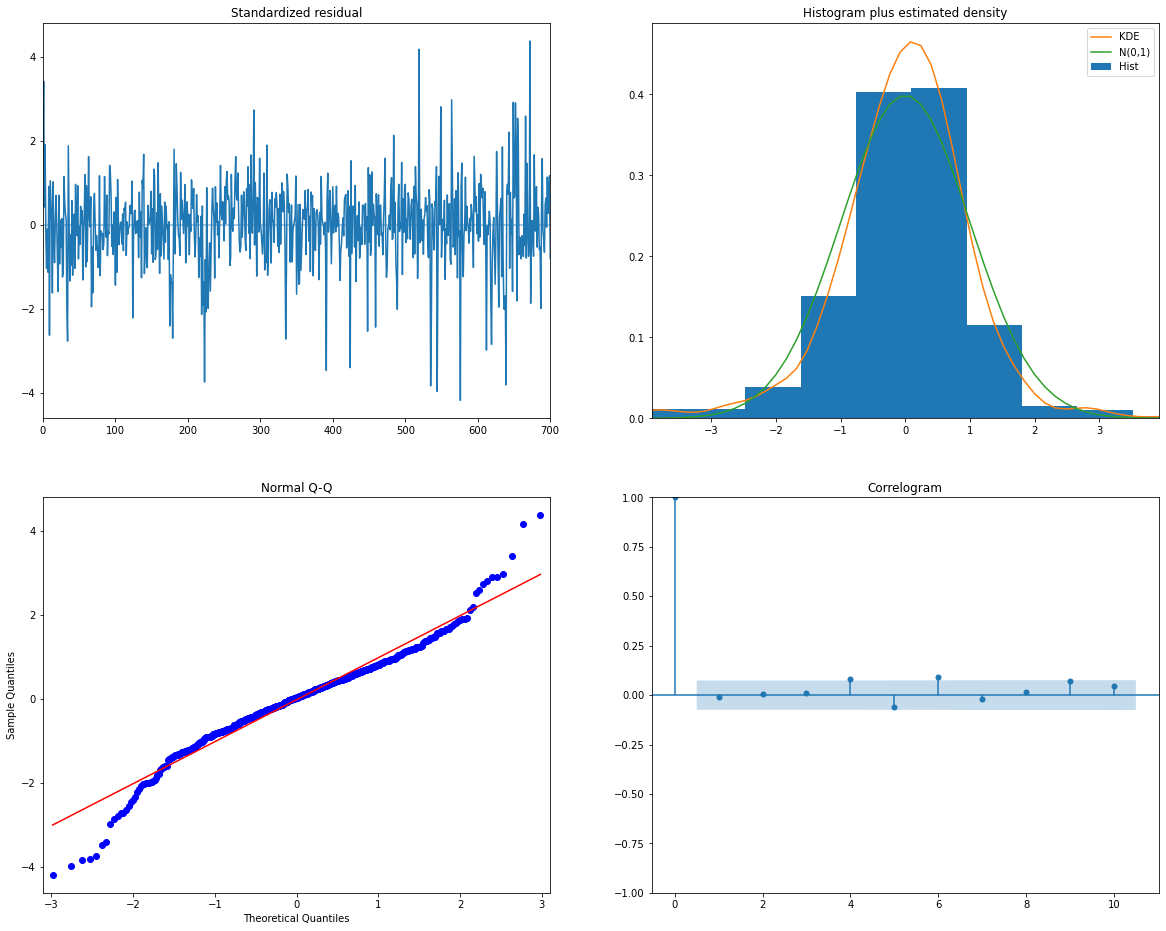

In [133]:
stepwise_model.plot_diagnostics();

Still we have small lag at day 6 on correlogram. Other than that we are close to normal distrubition but there is still something that we could not explain.

In [134]:
print('auto-fit order: :', stepwise_model.order)
print('auto-fit seasonal_order: :', stepwise_model.seasonal_order)

auto-fit order: : (1, 0, 0)
auto-fit seasonal_order: : (2, 1, 0, 30)


Let's also look at GARCH model

In [135]:
from arch import arch_model
model_arch = arch_model(ts , vol='garch', p=1, o=0, q=1)
result_arch = model_arch.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 671527846574.3623
Iteration:      2,   Func. Count:     14,   Neg. LLF: 413123805.65028614
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1028.3534929226328
Iteration:      4,   Func. Count:     27,   Neg. LLF: 976.6489999438984
Iteration:      5,   Func. Count:     33,   Neg. LLF: 973.014353925699
Iteration:      6,   Func. Count:     38,   Neg. LLF: 973.124178698263
Iteration:      7,   Func. Count:     44,   Neg. LLF: 972.9664077951472
Iteration:      8,   Func. Count:     49,   Neg. LLF: 972.9662264424769
Iteration:      9,   Func. Count:     54,   Neg. LLF: 972.9661770443382
Iteration:     10,   Func. Count:     59,   Neg. LLF: 972.9661720565232
Iteration:     11,   Func. Count:     63,   Neg. LLF: 972.9661720563363
Optimization terminated successfully    (Exit mode 0)
            Current function value: 972.9661720565232
            Iterations: 11
            Function evaluations: 63
            Gradient evaluations: 11

In [136]:
print(result_arch.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                logDiff   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -972.966
Distribution:                  Normal   AIC:                           1953.93
Method:            Maximum Likelihood   BIC:                           1972.31
                                        No. Observations:                  731
Date:                Wed, Jun 16 2021   Df Residuals:                      730
Time:                        15:19:21   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0903  4.039e-02      2.236  2.538e-02 [1.113e-0

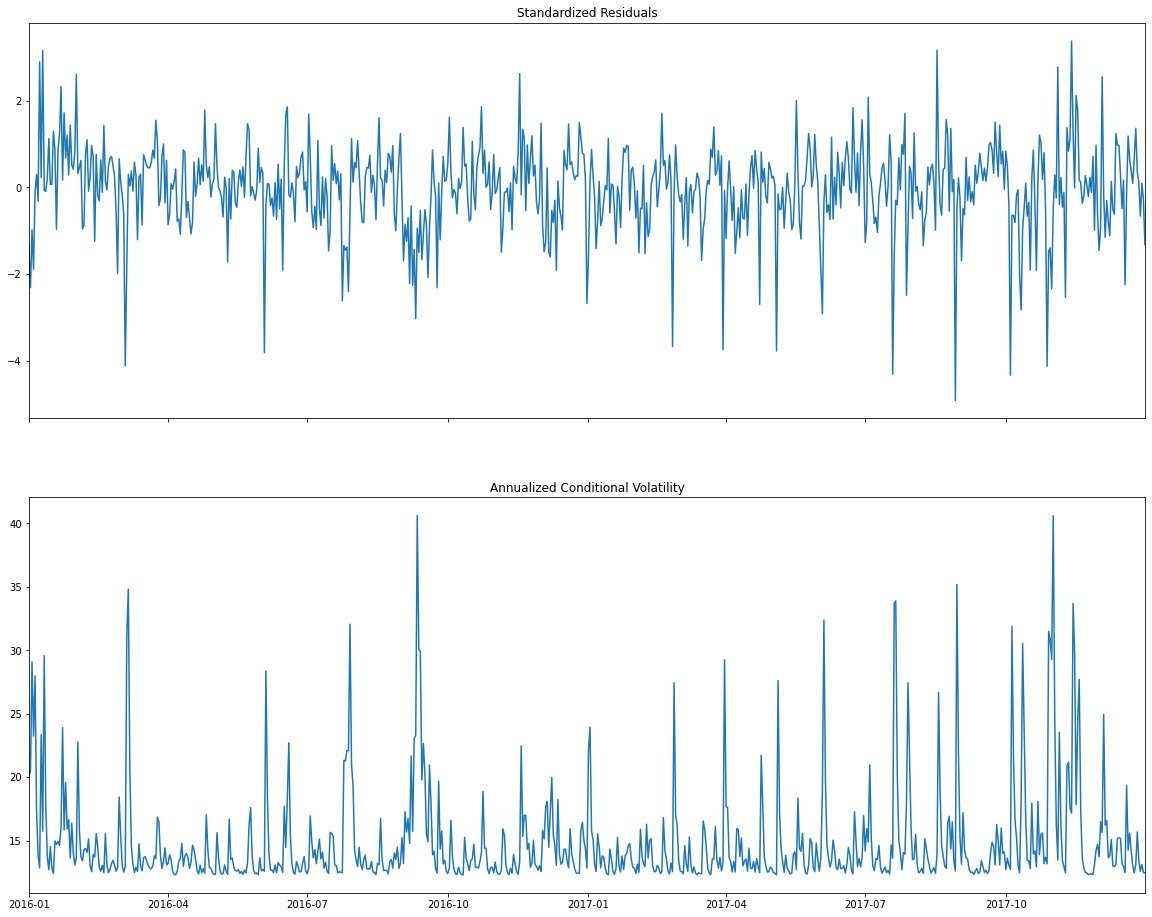

In [137]:
fig = result_arch.plot(annualize="D")